<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-vector-dataset" data-toc-modified-id="Input-vector-dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input vector dataset</a></span><ul class="toc-item"><li><span><a href="#Vector-data" data-toc-modified-id="Vector-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Vector data</a></span></li><li><span><a href="#Spatial-reference" data-toc-modified-id="Spatial-reference-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Spatial reference</a></span></li><li><span><a href="#Get-a-projected-polygon" data-toc-modified-id="Get-a-projected-polygon-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Get a projected polygon</a></span><ul class="toc-item"><li><span><a href="#Get-geographic-GeoJSON" data-toc-modified-id="Get-geographic-GeoJSON-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Get geographic GeoJSON</a></span></li><li><span><a href="#Plot-with-matplotlib." data-toc-modified-id="Plot-with-matplotlib.-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Plot with <code>matplotlib</code>.</a></span></li><li><span><a href="#Get-projected-GeoJSON" data-toc-modified-id="Get-projected-GeoJSON-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Get projected GeoJSON</a></span></li></ul></li></ul></li><li><span><a href="#Harmony-API" data-toc-modified-id="Harmony-API-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Harmony API</a></span><ul class="toc-item"><li><span><a href="#Inputs" data-toc-modified-id="Inputs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Inputs</a></span><ul class="toc-item"><li><span><a href="#Collection-metadata" data-toc-modified-id="Collection-metadata-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Collection metadata</a></span></li><li><span><a href="#Granule-metadata" data-toc-modified-id="Granule-metadata-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Granule metadata</a></span></li></ul></li><li><span><a href="#Granule-url" data-toc-modified-id="Granule-url-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Granule url</a></span></li><li><span><a href="#Granule-data" data-toc-modified-id="Granule-data-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Granule data</a></span><ul class="toc-item"><li><span><a href="#Open-with-netCDF4" data-toc-modified-id="Open-with-netCDF4-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Open with <code>netCDF4</code></a></span></li><li><span><a href="#Open-with-xarray" data-toc-modified-id="Open-with-xarray-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Open with <code>xarray</code></a></span></li><li><span><a href="#Plot-variable-sea_surface_temperature" data-toc-modified-id="Plot-variable-sea_surface_temperature-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>Plot variable <code>sea_surface_temperature</code></a></span></li><li><span><a href="#Mask-to-polygon-extent" data-toc-modified-id="Mask-to-polygon-extent-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>Mask to polygon extent</a></span></li></ul></li><li><span><a href="#Process-a-time-series" data-toc-modified-id="Process-a-time-series-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Process a time series</a></span></li></ul></li></ul></div>

**Please run this Earthdata authentication snippet before continuing:**

In [1]:
from urllib import request, parse
from http.cookiejar import CookieJar
import getpass
import netrc


def setup_earthdata_login_auth(endpoint):
    """
    Set up the request library so that it authenticates against the given Earthdata Login
    endpoint and is able to track cookies between requests.  This looks in the .netrc file 
    first and if no credentials are found, it prompts for them. 
    
    Valid endpoints include:
      
      uat.urs.earthdata.nasa.gov: Earthdata Login UAT (Harmony's current default)
      urs.earthdata.nasa.gov:     Earthdata Login production

    """
    try:
        username, _, password = netrc.netrc().authenticators(endpoint)
    except (FileNotFoundError, TypeError):
        # FileNotFound = There's no .netrc file
        # TypeError = The endpoint isn't in the netrc file, causing the above to try unpacking None
        print('Please provide your Earthdata Login credentials to allow data access')
        print('Your credentials will only be passed to %s and will not be exposed in Jupyter' % (endpoint))
        username = input('Username:')
        password = getpass.getpass()

    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, endpoint, username, password)
    auth = request.HTTPBasicAuthHandler(manager)

    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)
    

setup_earthdata_login_auth('uat.urs.earthdata.nasa.gov')

# Get L2 SST via Harmony API for a polygon study area in projected CRS

This notebook is a mish-mash of notebooks. I wanted to validate the outputs from Mike's demo notebook here:     
https://github.com/podaac/tutorials/blob/master/notebooks/l2-regridding/reprojection%20notebook.md

I was interested in this part, specifically:       
https://github.com/podaac/tutorials/blob/master/notebooks/l2-regridding/reprojection%20notebook.md#access-level-2-swath-regridded-data

We'll try to take this a little closer to a real analysis scenario by subsetting GHRSST SST with the Harmony API for the area in the polygon above.

## Input vector dataset

Import json, GDAL/OGR/OSR, and numpy.

In [2]:
from json import loads, dumps
from osgeo import gdal, ogr, osr
from netCDF4 import Dataset
from pandas import DataFrame
import numpy as np

### Vector data 

We will read a simple polygon boundary for a region over hte Gulf of Mexico from inside the ZIP in the resources folder `resources/gulf_shapefile.zip`.

The data objects within a vector dataset conforming to the GDAL/OGR Vector Data Model:

* Layer(s)
* Feature(s)
* Geometries(s)

These steps grab the feature from the file (will also work for multiple features), and gets its spatial extent. They should work for any OGR dataset and SRS:

In [3]:
shp = "/vsizip/resources/gulf_shapefile.zip/shapefile2.shp"

shp = ogr.Open(shp)            # Open ESRI Shapefile (or other vector).
lyr = shp.GetLayer()           # Get first (and only) layer.
feat = lyr.GetFeature(0)       # Get layer's only feature.
geom = feat.GetGeometryRef()   # Get feature's geometry.
ext = lyr.GetExtent()          # Get rectangular extent of the geometry.

ext

(-97.92333884760556, -80.9344862109354, 19.2349555158823, 30.199837703950273)

### Spatial reference

The spatial reference module (`osr`) provides access to projection parameters and common geospatial transforms used by the GDAL API. 

This grabs the EPSG from any GDAL/OGR supported vector/raster dataset, if it exists. If it doesn't have an EPSG, `AutoIdentifyEPSG` will try to predict the EPSG based on other available projection parameters:

In [4]:
# Get the 'osr.SpatialReference' from the OGR Layer.
srs = lyr.GetSpatialRef()

# Try to look up an EPSG for the SRS object.
srs.AutoIdentifyEPSG()

# Get highest authority EPSG code (authority=None):
epsg = srs.GetAuthorityCode(None)

epsg

'4326'

So, the input vector dataset is in WGS84. But I want to request reprojected data from our example L2 swath dataset, specifically [`North_America_Albers_Equal_Area_Conic (EPSG:102008)`](https://epsg.io/102008).

We'll get the transformed vertices as part of the next step.

### Get a projected polygon

Now we'll plot the AEA Conic-projected polygon and retain the transformed polygon for later use. Some steps:

1. Get GeoJSON representation of the input polygon; select the 2d coordinate array (lon, lat).
2. Transform the array of coordinates to linear units (meters) in AEA conic, and plot on a basemap.
3. Make a copy of the original GeoJSON (in WGS84) and replace the array of coordinates with the new projected coordinates. 

The new GeoJSON string will be used to determine the inputs for our reproject/regrid operations through the Harmony API.

#### Get geographic GeoJSON

Get the polygon geometry as a JSON string and load it to a Python dictionary.

In [5]:
# Export the feature to JSON and load string to Python dictionary:
poly = loads(geom.ExportToJson())

# Get the array of coordinates from the GeoJSON dictionary:
crds = poly['coordinates'][0]

crds

[[-92.50277108026334, 29.56938225072281],
 [-83.7769790645417, 30.199837703950273],
 [-80.9344862109354, 24.928609732834346],
 [-84.63633736912035, 21.404467339404434],
 [-89.32975580181909, 21.096419248573053],
 [-91.0484724109764, 19.2349555158823],
 [-96.20462223844827, 19.297357882373674],
 [-97.92333884760556, 23.117355263556085],
 [-97.13008502799451, 27.537299169977643],
 [-92.50277108026334, 29.56938225072281]]

Get the 2d array as two lists of longitudes and latitudes, and get the xy for the polygon centroid as a tuple:

In [6]:
# Get the longitudes and latitudes as two lists.
lons = [c[0] for c in crds]
lats = [c[1] for c in crds]

# Get the centroid of the OGR Geometry:
cent = geom.Centroid()

# Get arguments for plot. Add a 2.5-deg buffer, center map on centroid.
margs = {
    'llcrnrlat': min(lats) - 2.5,
    'llcrnrlon': min(lons) - 2.5,
    'urcrnrlat': max(lats) + 2.5,
    'urcrnrlon': max(lons) + 2.5,
    'lat_0': cent.GetY(), 
    'lon_0': cent.GetX(),
}

margs

{'llcrnrlat': 16.7349555158823,
 'llcrnrlon': -100.42333884760556,
 'urcrnrlat': 32.69983770395027,
 'urcrnrlon': -78.4344862109354,
 'lat_0': 24.910825071802158,
 'lon_0': -89.98954251670611}

#### Plot with `matplotlib`.

**TODO:** Re-do this plot using `cartopy`, the replacement for `mpl_toolkits.basemap`.

The subset area is shown by the gray overlay in the map below:

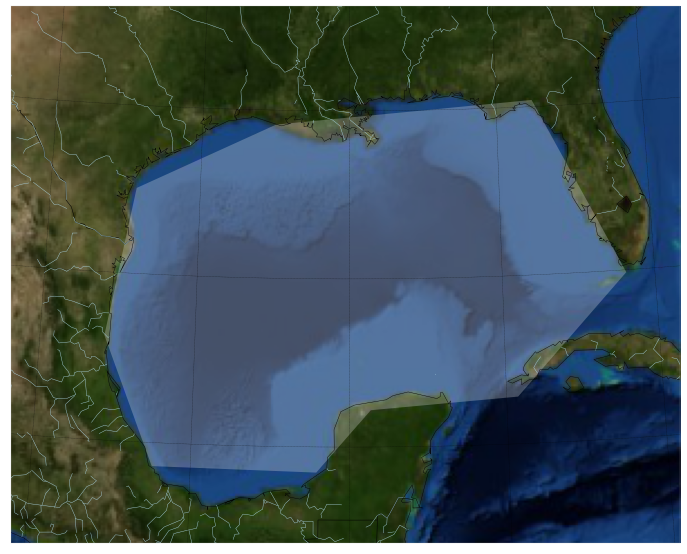

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap

# Make a matplotlib figure:
plt.figure(figsize=(12, 12))

# Create Basemap with albers equal area and low feature resolution:
m = Basemap(**margs, projection="aea", resolution="l")

# Add your preferred Basemap built-in layers,
m.bluemarble()
m.drawcountries()
m.drawrivers(color="lightblue", linewidth=0.4)
m.drawcoastlines(color="black", linewidth=0.4)
m.drawparallels(range(20, 35, 5), color="black", linewidth=0.3, alpha=0.05)
m.drawmeridians(range(-105, -75, 5), color="black", linewidth=0.3, alpha=0.05)
m.drawmapboundary(color="lightgray", linewidth=0.2)

# Convert geographic coordinates to map (i.e. plot) coordinates:
x, y = m(x=lons, y=lats)

# Zip back to a 2d array; create a matplotlib Polygon:
poly = Polygon(list(zip(x,y)), facecolor="white", alpha=0.25, linewidth=1.2)

# Then plot the polygon in red:
plt.gca().add_patch(poly)

#### Get projected GeoJSON

Make a copy of the dictionary representation of the GeoJSON vector in WGS84 (`poly`) and replace the `coordinates` in feature's geometry with the new coordinates (in meters).

```python
{
    "type": "Feature",
    "geometry": {
        "type": "Polygon", 
        "coordinates": [  # Replace GeoX,GeoY with X,Y meters.
            [  
                [<LONGITUDE>, <LATITUDE>],  # vert 0,
                [<LONGITUDE>, <LATITUDE>],  # vert 1,
                [<LONGITUDE>, <LATITUDE>],  # vert 2, etc
                ...
            ]
        ]
     },
    "properties": { ... },
    "id": 0
}
```

Pretty simple. 

We're duplicating the GeoJSON representation of the **feature (`feat`)**, not the geometry (`geom`). Don't forget that the coordinates list (2 dimensional) is nested inside ANOTHER list.

And pretty print the first ~20 lines of the new GeoJSON feature:

In [8]:
# Get input feature as GeoJSON, load to dictionary, and make a copy.
aeac = loads(feat.ExportToJson()).copy()

# Replace feature>geometry>coordinates with new xy coordinates:
aeac['geometry']['coordinates'] = [list(zip(x,y))]


print("\n".join(dumps(aeac, indent=2).split('\n')[:18])+"\n\n\t...\n")

{
  "type": "Feature",
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          876768.6167571892,
          1382849.298667006
        ],
        [
          1720160.4159990326,
          1464116.6166564333
        ],
        [
          2033048.302179177,
          895532.7400397846
        ],

	...



## Harmony API

The Harmony API usage that follows is shamelessly lifted from [Mike's UWG Demo notebook](https://github.com/podaac/tutorials/blob/master/notebooks/l2-regridding/reprojection%20notebook.md#access-level-2-swath-regridded-data)
(the `sds/swot-reproject` part).

**We're going to try to do a simple workflow** - one timestep at first, then a time series.

1. Use the Harmony API to process a gridded subset of L2 swath sea surface temperature and reproject it to Albers matching our new GeoJSON polygon. 
  * Subset should be the minimum envelope around the Gulf of Mexico polygon.
  * Determine sensible output cell dimensions when switching between linear, angular units.
2. Mask the rectangular subset returned by the Harmony API with the Gulf of Mexico polygon.

Stretch goal is to process time series, aggregate over some interval.

### Inputs

**First, from the CMR Collection and Granule:**

Get the CMR records at the urls below and harvest some inputs to our Harmony request. 

* Collection: https://cmr.uat.earthdata.nasa.gov/search/collections.umm_json?concept-id=C1234724470-POCLOUD&pretty=true
* Granule: https://cmr.uat.earthdata.nasa.gov/search/granules.umm_json?concept-id=G1234734747-POCLOUD&pretty=true

Make a generic function because we might do more searches later:

In [9]:
def _dumps(data: dict, indent: int=2, **kwargs):
    print(dumps(data, indent=indent, **kwargs))


def cmrsearch(end: str, uat: bool=True, **kwargs):
    """
    Returns a dictionary of CMR results for the input parameters.
    
    Parameters
    ----------
    end (str): search ('collections', 'granules', etc )
    uat (bool=True): Format the URL to the UAT CMR if True. 
    **kwargs: Supply query parameters as key, value pairs.
    
    Returns
    -------
    Dictionary representation of the 'umm_json' response.
    
    """
    # Insert an empty string if 'uat' is False.
    uatfmt = '.uat' if uat else ''
    
    # Format the search url with '.uat' if uat is True.
    search = f"https://cmr{uatfmt}.earthdata.nasa.gov/search"

    # Format the query parameters and values (kwargs) to a string:
    query = "&".join([f"{p}={v}" for p,v in kwargs.items()])
    
    # Download the data at the URL.
    response = request.urlopen(f"{search}/{end}.umm_json?{query}")
    
    # Decode, load the JSON string to a dict, return.
    return loads(response.read().decode())


#### Collection metadata

Get the collection record and display the `SpatialExtent` from its `umm` metadata:

In [10]:
cresults = cmrsearch('collections', **{'concept-id': "C1234724470-POCLOUD"})
collection = cresults['items'][0]

_dumps(collection['umm']['SpatialExtent'])

{
  "SpatialCoverageType": "HORIZONTAL",
  "HorizontalSpatialDomain": {
    "Geometry": {
      "CoordinateSystem": "CARTESIAN",
      "BoundingRectangles": [
        {
          "WestBoundingCoordinate": -180.0,
          "NorthBoundingCoordinate": 90.0,
          "EastBoundingCoordinate": 180.0,
          "SouthBoundingCoordinate": -90.0
        }
      ]
    },
    "ResolutionAndCoordinateSystem": {
      "GeodeticModel": {
        "HorizontalDatumName": "World Geodetic System 1984",
        "EllipsoidName": "WGS 84",
        "SemiMajorAxis": 6378137,
        "DenominatorOfFlatteningRatio": 298.2572236
      }
    }
  },
  "GranuleSpatialRepresentation": "CARTESIAN"
}


Take a look at the info in the `ResolutionAndCoordinateSystem` field in `SpatialExtent`.

Knowing the "GeodeticModel", we can calculate optimal pixel sizes for our projected outputs (we'd also carefully consider the swath pixel resolutions, as calculated according to their offset from the nadir/orbit path).

We need the spatial extent of the source granule to really get it right, but we can calculate good sizes from the latitude longitude extent of our input polygon (also the extent of our output subset) and the info in `ResolutionAndCoordinateSystem`:

#### Granule metadata

We'll do a spatial search for all the granules with footprints overlapping our polygon.

We can submit a polygon to the CMR Search API as a comma separated list of numerics to parameter `polygon`. Make the flat list of coordinates in lon,lat order:

Remember that we set the 2d list of lon,lat coordinates to `crds` a long time back. Use `numpy` to convert the list of xy vertices/coordinates into a flat, comma separated string. 
* You need to reverse the 2d array before flattening so they're arranged from the pole.
* Make sure there aren't any white spaces.

In [11]:
polygon = ",".join([str(round(v, 4)) for v in np.array(crds)[::-1].flatten()])

polygon

'-92.5028,29.5694,-97.1301,27.5373,-97.9233,23.1174,-96.2046,19.2974,-91.0485,19.235,-89.3298,21.0964,-84.6363,21.4045,-80.9345,24.9286,-83.777,30.1998,-92.5028,29.5694'

Get CMR granules that overlap our input polygon that are from collection `C1234724470-POCLOUD`, and print the number of results:

In [12]:
granules = cmrsearch('granules', **{
    'collection_concept_id': collection['meta']['concept-id'],
    'polygon': polygon,
    'page_size': 200,
})

granules['hits']

196

Reformat the CMR Search (`meta`) and UMM (`umm`) metadata for the granules as two `pandas.DataFrame` for convenience:

In [13]:
gmeta = DataFrame.from_records([r['meta'] for r in granules['items']])
gumm = DataFrame.from_records([r['umm'] for r in granules['items']])

gmeta.iloc[1]

concept-type                                               granule
concept-id                                     G1234724584-POCLOUD
revision-id                                                      1
native-id        20200101074500-JPL-L2P_GHRSST-SSTskin-MODIS_A-...
provider-id                                                POCLOUD
format                           application/vnd.nasa.cmr.umm+json
revision-date                                 2020-05-14T23:51:14Z
Name: 1, dtype: object

**Get the time bounds of each granule as new columns.**

This would be better if it has start and end time columns. Oh - they here, too:

```json
{
  "TemporalExtent": {
    "RangeDateTime": {
      "EndingDateTime": "2020-01-01T07:44:59.000Z",
      "BeginningDateTime": "2020-01-01T07:40:00.000Z"
```

Apply a lambda to select `BeginningDateTime`, `EndingDateTime` over the  `TemporalExtent` column of the UMM metadata table (`umm`) into two new columns in the search metadata table (`meta`):

In [14]:
T = gumm.TemporalExtent

gmeta['BeginningDateTime'] = T.apply(lambda x: x['RangeDateTime']['BeginningDateTime'])
gmeta['EndingDateTime'] = T.apply(lambda x: x['RangeDateTime']['EndingDateTime'])

gmeta[[
    'concept-type',
    'concept-id',
    'BeginningDateTime',
    'EndingDateTime',
    'provider-id',
    'revision-date',
    'revision-id',
]].head(5)

,concept-type,concept-id,BeginningDateTime,EndingDateTime,provider-id,revision-date,revision-id
0,granule,G1234724573-POCLOUD,2020-01-01T07:40:00.000Z,2020-01-01T07:44:59.000Z,POCLOUD,2020-05-14T23:51:12Z,1
1,granule,G1234724584-POCLOUD,2020-01-01T07:45:00.000Z,2020-01-01T07:49:59.000Z,POCLOUD,2020-05-14T23:51:14Z,1
2,granule,G1234724623-POCLOUD,2020-01-01T09:20:00.000Z,2020-01-01T09:24:59.000Z,POCLOUD,2020-05-14T23:51:16Z,1
3,granule,G1234724776-POCLOUD,2020-01-01T18:35:00.000Z,2020-01-01T18:39:59.000Z,POCLOUD,2020-05-14T23:51:44Z,1
4,granule,G1234724726-POCLOUD,2020-01-01T18:40:00.000Z,2020-01-01T18:44:59.000Z,POCLOUD,2020-05-14T23:51:41Z,1


**Now get the spatial bounds of all the granules (from `SpatialExtent`) as four new columns.**

This one is a little trickier. It's deeply nested:

```json
{
  "SpatialExtent": {
    "HorizontalSpatialDomain": {
      "Geometry": {
        "BoundingRectangles": [
          {
            "WestBoundingCoordinate": -100.303,
            "SouthBoundingCoordinate": 19.767,
            "EastBoundingCoordinate": -71.362,
            "NorthBoundingCoordinate": 40.999
          }
```

Make a function to return the four coordinates in a list in the same order as above.

In [15]:
def _gSpatialExtent(SpatialExtent: dict):
    
    # Loop through three nested depths, replacing SpatialExtent.
    for key in ['HorizontalSpatialDomain', 'Geometry', 'BoundingRectangles']:
        SpatialExtent = SpatialExtent[key]

    # Get value of each extent limit as a list and return (WSEN).
    return list([crd.values() for crd in SpatialExtent][0])


_gSpatialExtent(gumm.SpatialExtent.iloc[0])

[-100.303, 19.767, -71.362, 40.999]

Apply the function over the `SpatialExtent` column to make a 2d array of coordinates. Print the first five:

In [16]:
gSpatialExtent = np.array(gumm.SpatialExtent.apply(_gSpatialExtent).tolist())

gSpatialExtent[:5]

array([[-100.303,   19.767,  -71.362,   40.999],
       [-103.474,    2.054,  -78.16 ,   23.053],
       [-125.662,   15.841,  -97.881,   36.999],
       [ -90.537,    2.67 ,  -65.087,   23.627],
       [ -97.441,   20.361,  -68.234,   41.565]])

Tranpose the 2d array and add the four tall arrays to `gmeta` as columns:

In [17]:
gmeta['West'], gmeta['South'], gmeta['East'], gmeta['North'] = gSpatialExtent.T.tolist()

gmeta[[
    'concept-type', 
    'concept-id',
    'BeginningDateTime', 
    'EndingDateTime',
    'West',
    'South',
    'East',
    'North',
]].head(5)

,concept-type,concept-id,BeginningDateTime,EndingDateTime,West,South,East,North
0,granule,G1234724573-POCLOUD,2020-01-01T07:40:00.000Z,2020-01-01T07:44:59.000Z,-100.303,19.767,-71.362,40.999
1,granule,G1234724584-POCLOUD,2020-01-01T07:45:00.000Z,2020-01-01T07:49:59.000Z,-103.474,2.054,-78.160,23.053
2,granule,G1234724623-POCLOUD,2020-01-01T09:20:00.000Z,2020-01-01T09:24:59.000Z,-125.662,15.841,-97.881,36.999
3,granule,G1234724776-POCLOUD,2020-01-01T18:35:00.000Z,2020-01-01T18:39:59.000Z,-90.537,2.670,-65.087,23.627
4,granule,G1234724726-POCLOUD,2020-01-01T18:40:00.000Z,2020-01-01T18:44:59.000Z,-97.441,20.361,-68.234,41.565


**We also need to supply a `variable` input.**

See if the collection record lists any `associations` to CMR variables in its CMR search metadata.

In [18]:
"associations" in collection['meta']

False

No associations at all... We can get a list of variables over OPeNDAP but not from any of the access points in the UAT records.

We know this dataset to have a variable `sea_surface_temperature`:
https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L2P/MODIS_A/JPL/v2019.0/2006/033/20060202030506-JPL-L2P_GHRSST-SSTskin-MODIS_A-N-v02.0-fv01.0.nc.html

Let's first get a subset of the first granule in the table for all variables by passing `variable=all`.

### Granule url

Now we're gonna prepare the url to request a subset of the first granule via the Harmony API L2 swath service. Here's the granule's search metadata:

In [19]:
gran0 = gmeta.iloc[0]

gran0

concept-type                                                   granule
concept-id                                         G1234724573-POCLOUD
revision-id                                                          1
native-id            20200101074000-JPL-L2P_GHRSST-SSTskin-MODIS_A-...
provider-id                                                    POCLOUD
format                               application/vnd.nasa.cmr.umm+json
revision-date                                     2020-05-14T23:51:12Z
BeginningDateTime                             2020-01-01T07:40:00.000Z
EndingDateTime                                2020-01-01T07:44:59.000Z
West                                                          -100.303
South                                                           19.767
East                                                           -71.362
North                                                           40.999
Name: 0, dtype: object

These definitions will get better when I find more info about them.

>The Harmony API accepts several query parameters related to regridding and interpolation in addition to the reprojection parameters above:
>
>* `outputCrs`: a GDAL-supported projecction identifier, like EPSG, Proj, OGC WKT, etc.   
>* `interpolation`: one of ```('near', 'bilinear')```,
>* `scaleSize`: a comma-separated pair of floats giving `x,y` cell dimensions (?),
>* `scaleExtent`: four comma-separated floats giving `xmin,ymin,xmax,ymax`
>* `width`: (? output x dimension size, I think)
>* `height`: (? output y dimension size, I think)
>
>An error is returned if both `scaleSize` and `width`/`height` parameters are both provided (only one or the other can be used).

We'll use the original input feature's GeoJSON representation (converted to dictionary) for our spatial domain as we call Harmony API to perform subset, re-project, and re-grid operations.

And `EPSG:102008` (Albers) is still our preferred output srs:

In [20]:
def rmin(data: list, digits: int=5):
    return round(min(data), digits)

def rmax(data: list, digits: int=5):
    return round(max(data), digits)


param = {
    'granuleid': gmeta.iloc[0]['concept-id'],
    'variable': 'all',
    'outputCrs': "EPSG:102008",
    'interpolation': "near",
    'scaleSize': None,  # f"{1000.0},{1000.0}",
    'scaleExtent': None,  # f"{rmin(x)},{rmin(y)},{rmax(x)},{rmax(y)}",
    'width': None, 
    'height': None, 
}

param

{'granuleid': 'G1234724573-POCLOUD',
 'variable': 'all',
 'outputCrs': 'EPSG:102008',
 'interpolation': 'near',
 'scaleSize': None,
 'scaleExtent': None,
 'width': None,
 'height': None}

Join `param` twice into query string:

* Join parameters to values with `=`
* Join `parameter=value` strings together with `&`

In [21]:
query = "&".join([f"{p}={v}" for p, v in param.items() if v is not None])

query

'granuleid=G1234724573-POCLOUD&variable=all&outputCrs=EPSG:102008&interpolation=near'

Format endpoint to L2 subset service for target collection:

In [22]:
conceptid = collection['meta']['concept-id']
variable = "all"
end = f"{conceptid}/ogc-api-coverages/1.0.0/collections/{variable}/coverage/rangeset"

end

'C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset'

And append endpoint+parameters to Harmony API base url:

In [23]:
url = f"https://harmony.uat.earthdata.nasa.gov/{end}?{query}"

print(url)

https://harmony.uat.earthdata.nasa.gov/C1234724470-POCLOUD/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?granuleid=G1234724573-POCLOUD&variable=all&outputCrs=EPSG:102008&interpolation=near


### Granule data

Submit the subset request and wait for the response. Hope for `200`!

In [24]:
# Retrieve the data at the URL:
response = request.urlopen(url)

# Read the response data:
data = response.read()

response.status

200

#### Open with `netCDF4`

`netCDF4` will open the file without writing to disk. Open it, print its variables, then close it again:

In [25]:
ds = Dataset('name', mode="r", memory=data)
list(ds.variables)
ds.close()

#### Open with `xarray`

You can also open the output data file object with `xarray` if you have `h5netcdf` (also developed by S. Hoyer at el., creators of `xarray`). You need to pass the file to `xarray.open_dataset` as an `io.BytesIO` object.


(These values aren't auto-scaling or auto-masking properly. I disable auto-mask here to allow us to proceed.)

In [26]:
from io import BytesIO
import xarray as xr

ds = xr.open_dataset(BytesIO(data), engine="h5netcdf", mask_and_scale=False)
ds

<xarray.Dataset>
Dimensions:                      (time: 1, x: 1887, y: 1730)
Coordinates:
  * time                         (time) float32 0.0
  * x                            (x) float64 -4.311e+05 -4.298e+05 ... 2.044e+06
  * y                            (y) float64 -2.15e+06 -2.149e+06 ... 1.188e+05
Data variables:
    quality_level_4um            (time, y, x) int8 ...
    albers_conical_equal_area    |S1 ...
    sea_surface_temperature_4um  (time, y, x) int16 ...
    sses_bias_4um                (time, y, x) int8 ...
    sses_standard_deviation_4um  (time, y, x) int8 ...
    sst_dtime                    (time, y, x) timedelta64[ns] ...
    dt_analysis                  (time, y, x) int8 ...
    l2p_flags                    (time, y, x) int16 ...
    sses_standard_deviation      (time, y, x) int8 ...
    sea_surface_temperature      (time, y, x) int16 ...
    sses_bias                    (time, y, x) int8 ...
    wind_speed                   (time, y, x) int8 ...
    quality_level                (time, y, x) int8 ...
Attributes:
    Conventions:                CF-1.7, ACDD-1.3
    title:                      MODIS Aqua L2P SST
    summary:                    Sea surface temperature retrievals produced a...
    references:                 GHRSST Data Processing Specification v2r5
    institution:                NASA/JPL/OBPG/RSMAS
    history:                    MODIS L2P created at JPL PO.DAAC
    comment:                    L2P Core without DT analysis or other ancilla...
    license:                    GHRSST and PO.DAAC protocol allow data use as...
    id:                         MODIS_A-JPL-L2P-v2019.0
    naming_authority:           org.ghrsst
    product_version:            2019.0
    uuid:                       f6e1f61d-c4a4-4c17-8354-0c15e12d688b
    gds_version_id:             2.0
    netcdf_version_id:          4.1
    date_created:               20200219T005212Z
    file_quality_level:         [3]
    spatial_resolution:         1km
    start_time:                 20200101T074000Z
    time_coverage_start:        20200101T074000Z
    stop_time:                  20200101T074459Z
    time_coverage_end:          20200101T074459Z
    northernmost_latitude:      [40.9994]
    southernmost_latitude:      [19.7666]
    easternmost_longitude:      [-71.3624]
    westernmost_longitude:      [-100.303]
    source:                     MODIS sea surface temperature observations fo...
    platform:                   Aqua
    sensor:                     MODIS
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  [0.01]
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  [0.01]
    acknowledgment:             The MODIS L2P sea surface temperature data ar...
    creator_name:               Ed Armstrong, JPL PO.DAAC
    creator_email:              edward.m.armstrong@jpl.nasa.gov
    creator_url:                http://podaac.jpl.nasa.gov
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L2P
    cdm_data_type:              swath
    startDirection:             Descending
    endDirection:               Descending
    day_night_flag:             Night

#### Plot variable `sea_surface_temperature`

In [28]:
sst = ds['sea_surface_temperature']

Plot `sea_surface_temperature` variable:

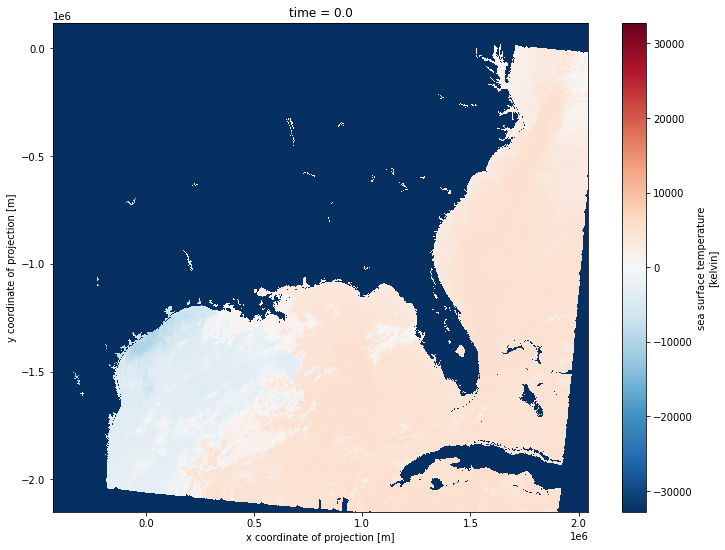

In [29]:
sst.plot(figsize=(12,9))

Next, we'll limit the data coverage to the area within our polygon mask.

#### Mask to polygon extent

### Process a time series